# Sentinel 2 cloud labelling <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[s2a_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2a_ard_granule), 

* **Special requirements:** The `rioxarray` Python package.
* **Prerequisites:** None.


## Description

We want to evaluate methods for detecting and subsequently masking clouds in Sentinel 2 satellite images. This notebook helps generate a labelled dataset of cloud and non-cloud pixels in these images. To do so, we follow this approach:

1. We load all available images of a given area.
2. We sort the images by how much cloud they have according to Sentinel 2's pre-packaged cloud mask, `fmask`.
3. We look at each image to see if it is fully cloud or fully not-cloud, and label these images accordingly.
4. We take a subset of images that are neither fully cloud nor fully not-cloud, and hand-draw cloud locations onto these images.
5. We end up with a set of labelled pixels.

***

## Getting started

Run all the cells in this section. You can then run the cells in the labelling sections, which will generate widgets that you can use to label cloud images.

### Load packages
Import Python packages that are used for the analysis.

In [3]:
%%bash
# Run this cell if you need to install rioxarray, e.g. on the sandbox.
pip install rioxarray

Processing /home/jovyan/.cache/pip/wheels/d0/d8/f9/caa0e5b4936f60d2f2156c9092c3c7c4a3abd9c8163c22d2ec/rioxarray-0.0.31-py3-none-any.whl


You should consider upgrading via the '/env/bin/python3 -m pip install --upgrade pip' command.


In [4]:
%matplotlib widget

import functools
import os
import sys
import datacube
from datacube.storage.masking import make_mask
import datacube.utils.cog
import geopandas as gpd
import ipyleaflet
from IPython.display import display
import ipywidgets as widgets
import matplotlib.cm
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import odc.ui
from odc.ui import with_ui_cbk
import rasterio.features
import rioxarray
from shapely.geometry import shape
import skimage.color as colour
import skimage.io
import sklearn.metrics
from tqdm.notebook import tqdm
import xarray

sys.path.append("../Scripts")
from dea_dask import create_local_dask_cluster
from dea_datahandling import load_ard, array_to_geotiff
from dea_plotting import rgb

### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [5]:
dc = datacube.Datacube(app='Sentinel_2_Cloud_Labelling')

We don't need to see all of the Sentinel 2 images at once, so we can lazily load them with Dask.

In [9]:
create_local_dask_cluster()

<Client: 'tcp://127.0.0.1:45609' processes=1 threads=8, memory=61.42 GB>

### Load the Sentinel 2 images

Choose a small area of Australia to label. We will use part of the Blue Mountains. We have a box that we want to use, so we can directly enter its side coordinates:

In [6]:
lon = (150.058, 150.392)
lat = (-33.896, -33.753)

But if we wanted to choose a 5km box centred on a location, we could instead do this:

```python
centre_deg = (lat, lon) = (-35.2809, 149.1300)
radius_m = 2500
m_to_deg = datacube.utils.geometry.crs_units_per_degree('WGS84', lat=lat, lon=lon)
radius_deg = radius_m / m_to_deg
lon = (lon - radius_deg, lon + radius_deg)
lat = (lat - radius_deg, lat + radius_deg)
```

(which would, in this case, choose a 5km box centred on Canberra).

Then we query the datacube. Eagerly (rather than lazily) loading the images would take a while because we load all images between 2015 and 2020. We use NBAR images rather than NBART images as clouds shouldn't be affected by terrain slope and there are many invalid pixels in the NBART images (not a problem in itself, but it does make it very hard to see clouds).

In [14]:
bands = ['nbar_red', 'nbar_green', 'nbar_blue', 'fmask']
rgb_bands = bands[:3]

query = {
    'x': lon,
    'y': lat,
    'time': ('2015-01', '2020-08'),
    'output_crs': 'EPSG:3577',
    'resolution': (-10, 10),
    'group_by': 'solar_day',
     'resampling': {'fmask': 'nearest', '*': 'average'},
}

In [18]:
chunks = {"time": 1, "x": 3000, "y": 3000}  # It doesn't really matter how big the chunks we load are, as long as time ~ 1.]

In [19]:
ds = dc.load(product='s2a_ard_granule',
             # progress_cbk=with_ui_cbk(),  # Add a progress bar like this if you decide to use eager loading.
             dask_chunks=chunks,
             measurements=bands,
             **query)

We can also load TSmask, a different masking method for Sentinel 2 clouds, for later comparison.

In [20]:
ds_tsmask = dc.load(
    's2_tsmask',
    dask_chunks=chunks,
    **query)

### Sorting by cloudiness

Using `fmask`, we'll sort by by the percentage of each time slice covered by cloud. This might not be entirely accurate, since `fmask` isn't entirely accurate, but it will give us an approximate order that will help us label later.

In [21]:
fmask = ds.fmask.load()

In [22]:
fmask.attrs['flags_definition']['fmask']['values']

{'0': 'nodata',
 '1': 'valid',
 '2': 'cloud',
 '3': 'shadow',
 '4': 'snow',
 '5': 'water'}

In [23]:
pc_cloudy = make_mask(fmask, fmask='cloud').values.mean(axis=(1, 2))

In [24]:
ds['cloudiness'] = xarray.DataArray(data=pc_cloudy, coords={'time': ds.time}, dims='time')

In [25]:
ds_sorted = ds.sortby('cloudiness')

Many images are fully cloud or fully not cloud.

In [26]:
plt.figure()
plt.hist(pc_cloudy, bins=30)
plt.xlabel('Cloud fraction')
plt.ylabel('Number of time stamps')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0, 0.5, 'Number of time stamps')

We can identify problem areas by looking for regions that tend to be more often masked than others.

In [27]:
plt.figure(figsize=(15, 4))
idx = abs(ds_sorted.cloudiness - 0.2).argmin()
ax = plt.subplot(1, 3, 1)
rgb(ds_sorted.isel(time=idx), ax=ax, bands=rgb_bands)
ax.set_title('20% cloudy RGB')
ax = plt.subplot(1, 3, 2)
ds_sorted.isel(time=idx).fmask.plot()
ax.set_title('20% cloudy fmask')
ax = plt.subplot(1, 3, 3)
make_mask(fmask, fmask='cloud').sum(axis=0).plot(ax=ax)
ax.set_title('Number of times masked')
plt.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In this case, there's no obvious problems, though the left side of the map is flagged more often (perhaps snow?).

## Full-image labels

When the full image is cloud-free or cloudy, we can get "free" validation data because the whole image gets the same label. This section includes a widget for rapidly labelling the cube.

If you're unsure, click "Mixed". If opaque or transparent cloud covers most of the image, that's enough to count the whole image as opaque or transparent.

In [49]:
%matplotlib widget

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
current_index = 0
labels = []

progress_bar = tqdm(total=ds_sorted.fmask.shape[0])

def plot_slice(index):
    if index >= ds_sorted.time.shape[0]:
        print('No more slices!')
        return
    ax.cla()
    rgb(ds_sorted.isel(time=index), ax=ax, bands=rgb_bands)
    # Preload the next image.
    ds_sorted.isel(time=index + 1).load()
plot_slice(current_index)

def handle_click(button):
    global current_index
    desc = button.description
    labels.append(desc)
    current_index += 1
    if current_index < len(ds_sorted.fmask):
        progress_bar.update(1)
        plot_slice(current_index)
    elif current_index == len(ds_sorted.fmask):
        progress_bar.update(1)  # Finishes the bar.
        print('No more slices!')
    else:
        print('No more slices!')

def handle_undo(button):
    global current_index
    current_index -= 1
    labels.pop()
    if current_index < len(ds_sorted.fmask):
        progress_bar.n -= 1
        progress_bar.last_print_n -= 1
        plot_slice(current_index)

button_all_clear = widgets.Button(
    description='Clear',
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    icon='sun')
button_all_cloud = widgets.Button(
    description='Opaque',
    button_style='',
    icon='cloud')
button_all_trans = widgets.Button(
    description='Transparent',
    button_style='',
    icon='wind')
button_mixed = widgets.Button(
    description='Mixed',
    button_style='',
    icon='cloud-sun')
button_undo = widgets.Button(
    description='Undo',
    button_style='info',
    icon='undo')
buttons = [button_mixed, button_all_clear, button_all_cloud, button_all_trans]
for button in buttons:
    button.on_click(handle_click)
button_undo.on_click(handle_undo)

widgets.VBox([widgets.HBox(buttons), button_undo])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Once they are all labelled to the best of your ability, save the labels:

In [51]:
labels = labels[:len(ds_sorted.time)]  # In case you hit a label button too many times at the end.

In [52]:
fn = 'full_image_labels_bluemountains_20200818.txt'
if not os.path.exists(fn):
    np.savetxt(fn, np.stack([ds_sorted.time.values.astype('<U29'), labels]).T, fmt='%s')

We can then load them back in to check everything worked OK.

In [29]:
saved_labels = np.loadtxt('full_image_labels_bluemountains_20200818.txt', dtype='<U29')
assert (saved_labels[:, 0] == ds_sorted.time.values.astype('<U29')).all()
if False: # I have this assertion disabled since I've restarted the notebook and `labels` doesn't exist any more.
    assert (labels == saved_labels[:, 1]).all()
labels = saved_labels[:, 1]
label_dates = saved_labels[:, 0]

In [30]:
plt.figure()
plt.hist(labels)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(array([17.,  0.,  0., 66.,  0.,  0., 29.,  0.,  0.,  2.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

If we want, we can now look at a simple confusion matrix with fmask.

In [31]:
fmask.flags_definition['fmask']['values']

{'0': 'nodata',
 '1': 'valid',
 '2': 'cloud',
 '3': 'shadow',
 '4': 'snow',
 '5': 'water'}

In [32]:
# Swiped from sklearn: https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalise=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalisation can be applied by setting `normalise=True`.
    """
    import itertools
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalise:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalised confusion matrix")
    else:
        print('Confusion matrix, without normalisation')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm[i, j]:.02f}',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [33]:
fm_cm = np.array([[0, 0], [0, 0]])
for label, label_date in zip(labels, label_dates):
    fm = fmask.sel(time=label_date)
    # How many pixels are masked that should be masked?
    if label == 'Clear':
        # Clear, so nothing should be masked.
        # Clear pixels are true negatives:
        fm_cm[0, 0] += (fm == 1).sum()
        # Cloud pixels are false positives:
        fm_cm[1, 0] += (fm == 2).sum()
    elif label in {'Opaque', 'Transparent'}:
        # Cloud, so everything should be masked.
        # Clear pixels are false negatives:
        fm_cm[0, 1] += (fm == 1).sum()
        # Cloud pixels are true positives:
        fm_cm[1, 1] += (fm == 2).sum()
plt.figure()
plot_confusion_matrix(fm_cm, ['Clear', 'Cloud'], normalise=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Normalised confusion matrix
[[9.67021325e-01 3.29786754e-02]
 [1.73017808e-05 9.99982698e-01]]


`fmask` is pretty good on this area!

## Partial-image labels

We now need to label some mixed images. These take a lot of time, so rather than labelling all of them we will sample evenly along the cloudiness axis and label nine of these samples.

In [67]:
mixed = labels == 'Mixed'

In [68]:
mixed_dates = label_dates[mixed]

In [69]:
mixed_cloudiness = np.array([(fmask.sel(time=d) == 2).mean() for d in mixed_dates])
selected_dates = []
for pc in np.linspace(0, 1, 9):
    selected_dates.append(np.datetime64(mixed_dates[abs(mixed_cloudiness - pc).argmin()]))

In [72]:
rgb(ds_sorted.sel(time=selected_dates), col='time', col_wrap=3, percentile_stretch=[0.02, 0.80], size=2, bands=rgb_bands)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Now let's label these. We'll use an ipyleaflet widget based on `Imagery_on_web_map.ipynb` and `interactive_polygons.ipynb`. At the moment there seems no good way to label multiple different polygons, so we will only fill in opaque cloud on this map.

In [85]:
def get_interactive_map(times, cloud_type='Opaque'):
    # Set up the map.
    bbox = ds.geobox.extent.to_crs('EPSG:4326').boundingbox
    zoom = odc.ui.zoom_from_bbox(bbox)
    center = (bbox.bottom + bbox.top) * 0.5, (bbox.right + bbox.left) * 0.5
    m = ipyleaflet.Map(
        center=center,
        zoom=zoom,
        scroll_wheel_zoom=True,  # Allow zoom with the mouse scroll wheel
        layout=widgets.Layout(
            width='600px',   # Set Width of the map to 600 pixels, examples: "100%", "5em", "300px"
            height='600px',  # Set height of the map
        ))
    
    def add_image_layer(time):
        # Add the image.
        # If the time axis has 0 shape, or >1 element, mk_image_overlay fails. https://github.com/opendatacube/odc-tools/issues/75
        # rioxarray doesn't like having more than x and y coordinate axes.
        img_layer = odc.ui.mk_image_overlay(
            ds_sorted.sel(time=time).drop('time').drop('cloudiness').rio.reproject(
                dst_crs='EPSG:3857', shape=ds.fmask.shape[1:], resampling=rasterio.warp.Resampling.bilinear),
            bands=rgb_bands,
            clamp=3000,
            fmt='jpeg')
        m.add_layer(img_layer)
        return img_layer
    
    idx = 0
    img_layer = add_image_layer(times[idx])
    
    # Add the drawing controls.
    fill_colours = {'Opaque': '#BEBEFF', 'Clear': '#BEFFBE', 'Transparent': '#FFBEBE', 'Shadow': '#BEBEBE'}
    feature_collection = {
        'type': 'FeatureCollection',
        'features': [],
    }
    
    
    for type_ in [cloud_type]:  # This is how I'd like to do multiple types in the one image, but I can't figure out how to label the icons.
                              # Update 11/08/20: Found a way to do this with CSS, but it's not pretty! TODO: Figure out a better way.
        draw_control = ipyleaflet.DrawControl()
        draw_control.polygon = {
            "shapeOptions": {
                "fillColor": fill_colours[type_],
                "color": fill_colours[type_],
            },
            "allowIntersection": False,
            'title': type_,
        }
        # Disable polyline and circlemarker controls so that only polygon remains.
        draw_control.polyline = {}
        draw_control.circlemarker = {}
        def handle_draw(self, action, geo_json):
            geo_json['properties']['type'] = type_
            geo_json['properties']['index'] = times[idx]
            feature_collection['features'].append(geo_json)
        draw_control.on_draw(handle_draw)
        draw_control.edit = False
        draw_control.remove = False
        m.add_control(draw_control)
        
    draw_control.edit = False  # Until syncing works.
    draw_control.remove = False  # Until syncing works.
    
    # Add next button.
    button_next = widgets.Button(
        description='Next',
        button_style='info',
        icon='next')
    def on_click(self):
        nonlocal idx
        nonlocal img_layer
        if idx + 1 < len(times):
            idx += 1
            m.remove_layer(img_layer)
            img_layer = add_image_layer(times[idx])
            draw_control.clear_polygons()
    button_next.on_click(on_click)
    
    # Need to return feature_collection or it will be stuck inside the function.
    return widgets.VBox([button_next, m]), feature_collection

In [113]:
map_, fc_opaque = get_interactive_map(selected_dates, cloud_type='Opaque')

# Here's a way to label multiple icons.
# from IPython.display import HTML, display
# import uuid
# map_class = 'cloud-labelling-map-{}'.format(uuid.uuid4())
# map_.add_class(map_class)
# def on_displayed(widget):
#     display(HTML(f'''
# <style>
# .{map_class} .leaflet-control .leaflet-draw-toolbar {{
#     background-color: white;
#     width: 80px;
# }}
# .{map_class} .leaflet-control:nth-of-type(2) .leaflet-draw-section:first-child .leaflet-draw-toolbar:first-child:after {{
#     content: 'Opaque';
# }}
# .{map_class} .leaflet-control:nth-of-type(3) .leaflet-draw-section:first-child .leaflet-draw-toolbar:first-child:after {{
#     content: 'Transparent';
# }}
# .{map_class} .leaflet-control:nth-of-type(4) .leaflet-draw-section:first-child .leaflet-draw-toolbar:first-child:after {{
#     content: 'Clear';
# }}
# </style>
# '''))
# map_.on_displayed(on_displayed)
print('Please label opaque clouds. Including transparent clouds is OK, since transparency will override opacity.')
map_

Please label opaque clouds. Including transparent clouds is OK, since transparency will override opacity.


In [128]:
def save_fc(fc, fn):
    # Convert datetimes into strings.
    features = []
    for feature in fc['features']:
        feature = feature.copy()
        feature['properties']['index'] = str(feature['properties']['index'])
        features.append(feature)
        
    if not os.path.exists(fn):
        gdf = gpd.GeoDataFrame.from_features(features)
        gdf.to_file(fn)
    else:
        raise RuntimeError('Label file already exists')

In [129]:
save_fc(fc_opaque, 'clouds_opaque_canberra.shp')
gdf_opaque = gpd.read_file('clouds_opaque_canberra.shp')

RuntimeError: Label file already exists

In [127]:
print('Please label transparent clouds.')
map_, fc_transparent = get_interactive_map(selected_dates, cloud_type='Transparent')
map_

Please label transparent clouds.


In [130]:
save_fc(fc_transparent, 'clouds_transparent_canberra.shp')
gdf_transparent = gpd.read_file('clouds_transparent_canberra.shp')

In [134]:
print('Please label cloud shadows. It\'s OK to include clouds too as they will be overriden by the cloud labels.')
map_, fc_shadow = get_interactive_map(selected_dates, cloud_type='Shadow')
map_

Please label cloud shadows. It's OK to include clouds too as they will be overriden by the cloud labels.


In [135]:
save_fc(fc_shadow, 'clouds_shadow_canberra.shp')
gdf_shadow = gpd.read_file('clouds_shadow_canberra.shp')

We now have 3 GeoDataFrames which we can easily combine into one for the whole dataset.

In [150]:
cloud_labels_gdf = gpd.pd.concat([gdf_opaque, gdf_transparent, gdf_shadow], ignore_index=True)  # here, index means the numeric row index

In [151]:
# pd.concat fails to produce a GDF in some versions of GPD; https://gis.stackexchange.com/questions/162659/joining-concat-list-of-similar-dataframes-in-geopandas
assert isinstance(cloud_labels_gdf, gpd.GeoDataFrame)

In [171]:
plt.figure()
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    timestamp = sorted(set(cloud_labels_gdf['index']))[i]
    subgdf = cloud_labels_gdf[cloud_labels_gdf['index'] == timestamp]
    subgdf[subgdf['type'] == 'Opaque'].plot(alpha=0.5, ax=ax, color='blue')
    subgdf[subgdf['type'] == 'Transparent'].plot(alpha=0.2, ax=ax, color='red')
    subgdf[subgdf['type'] == 'Shadow'].plot(alpha=0.5, ax=ax, color='grey')
    plt.axis('off')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/env/lib/python3.6/site-packages/geopandas/plotting.py:607: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/env/lib/python3.6/site-packages/geopandas/plotting.py:607: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/env/lib/python3.6/site-packages/geopandas/plotting.py:607: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/env/lib/python3.6/site-packages/geopandas/plotting.py:607: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


We can then rasterise the polygons.

In [196]:
rasters = []
timestamps = sorted(set(cloud_labels_gdf['index']))
for i in range(9):
    timestamp = timestamps[i]
    subgdf = cloud_labels_gdf[cloud_labels_gdf['index'] == timestamp].set_crs('EPSG:4326').to_crs('EPSG:3577')
    subgdf_opaque = subgdf[subgdf['type'] == 'Opaque']
    subgdf_transparent = subgdf[subgdf['type'] == 'Transparent']
    subgdf_shadow = subgdf[subgdf['type'] == 'Shadow']
    
    # Rasterise each cloud type separately.
    # Do this in order of precedence: Shadow is overriden by opaque is overriden by transparent.
    subgdfs = [subgdf_shadow, subgdf_opaque, subgdf_transparent]
    raster = np.zeros((ds_sorted.y.shape[0], ds_sorted.x.shape[0]), dtype=int)
    for k, subgdf in enumerate(subgdfs):
        if len(subgdf) == 0:
            continue

        raster_polygons = rasterio.features.rasterize(shapes=subgdf.geometry,
                                                      out_shape=(ds_sorted.y.shape[0], ds_sorted.x.shape[0]),
                                                      all_touched=True,
                                                      fill=0,
                                                      default_value=1,
                                                      transform=ds_sorted.fmask.geobox.transform).astype(bool)
        raster[raster_polygons] = k + 1
    rasters.append(raster)
rasters = np.array(rasters)
# Need to coerce to datetime64 to get .sel to match the index up correctly.
# Works fine without type changing for one element, but not a list.
rasters = xarray.DataArray(data=rasters, coords=ds_sorted.fmask.sel(time=np.array(timestamps).astype('datetime64')).coords)

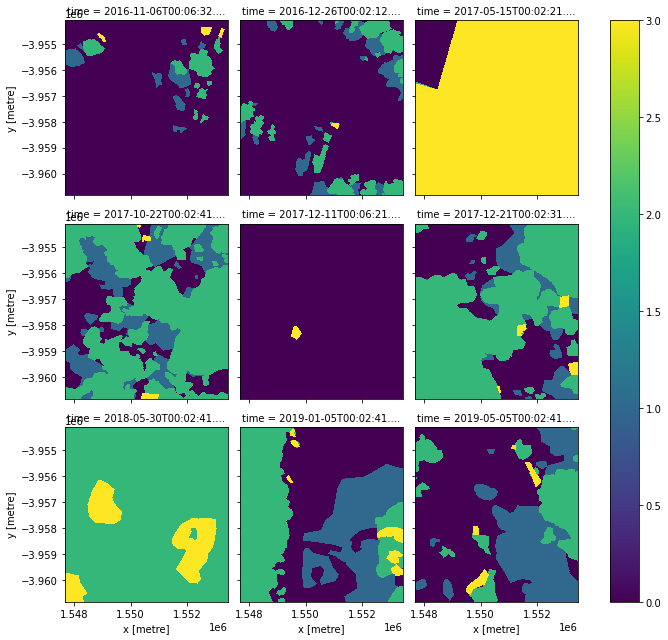

In [200]:
rasters.plot(col='time', col_wrap=3)

Then we make some xarrays for fully clear and fully opaque or transparent images.

In [206]:
clear_times = saved_labels[labels == 'Clear', 0]
all_clear = [xarray.zeros_like(fmask.sel(time=t)) for t in clear_times]
cloud_times = saved_labels[(labels == 'Opaque'), 0]
all_cloud = [xarray.zeros_like(fmask.sel(time=t)) + 2 for t in cloud_times]
trans_times = saved_labels[(labels == 'Transparent'), 0]
all_trans = [xarray.zeros_like(fmask.sel(time=t)) + 3 for t in trans_times]
full_labels = xarray.concat(all_clear + all_cloud + all_trans, dim='time')

In [207]:
all_labels = xarray.concat([rasters, full_labels], dim='time')

In [236]:
all_labels = all_labels.sortby('time').astype('uint8')

Finally we can write out to NetCDF (COG doesn't support the time coordinate).

In [240]:
del all_labels.time.attrs['units']

In [241]:
all_labels.to_netcdf('labels.nc')

In [247]:
read_labels = xarray.open_dataarray('labels.nc')

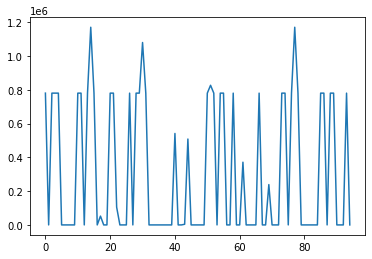

In [248]:
plt.figure()
plt.plot(read_labels.sum(dim=('x', 'y')))

Let's look at ts_mask and fmask on this same dataset.

In [249]:
test_times = read_labels.time

In [301]:
def fmask_to_labels(fm):
    labels = np.zeros_like(fm)
    # Valid
    labels[fm == 1] = 0
    # Shadow
    labels[fm == 3] = 1
    # Cloud
    labels[fm == 2] = 2
    return xarray.DataArray(labels, coords=fm.coords)

In [315]:
mask_cmap = matplotlib.colors.ListedColormap(['white', 'grey', 'blue', 'lightblue'])
mask_norm = matplotlib.colors.BoundaryNorm([0, 1, 2, 3, 4], cmap.N)

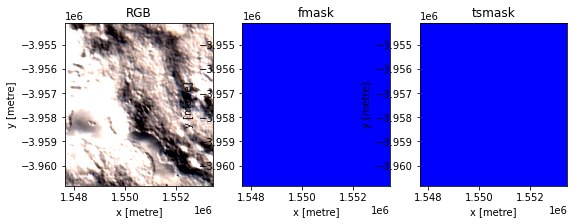

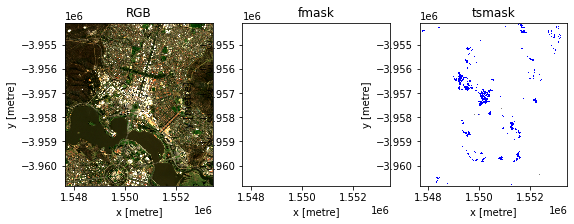

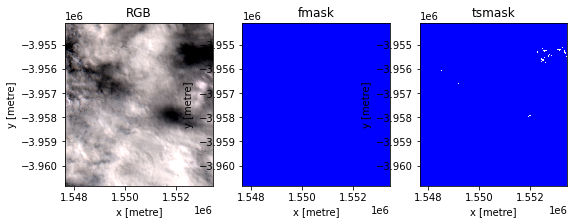

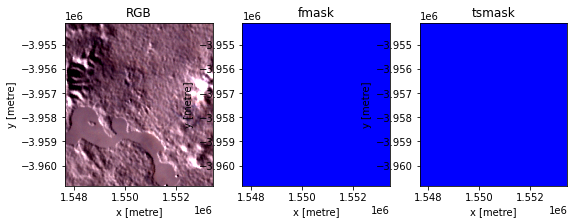

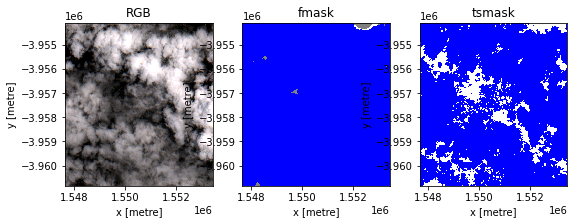

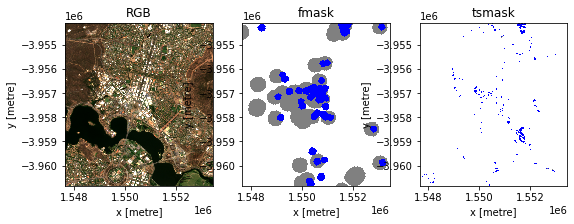

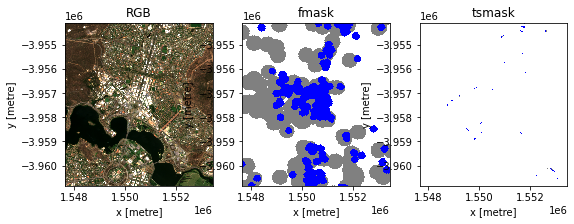

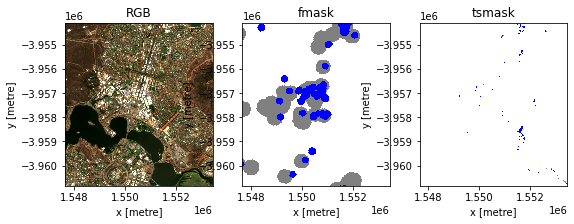

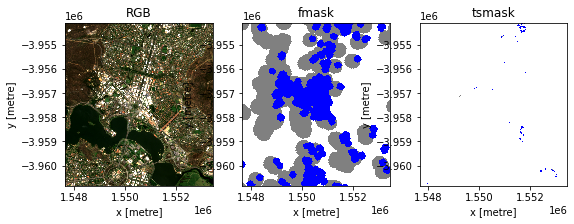

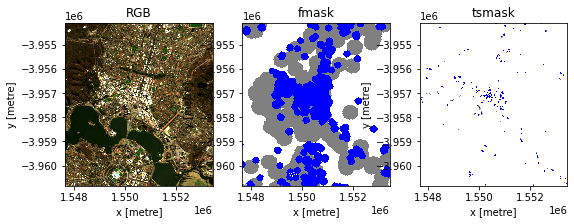

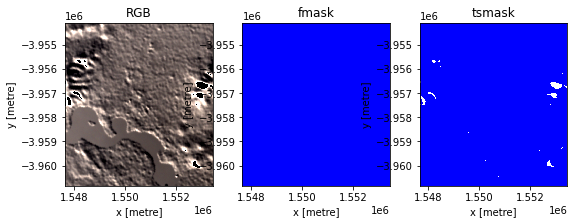

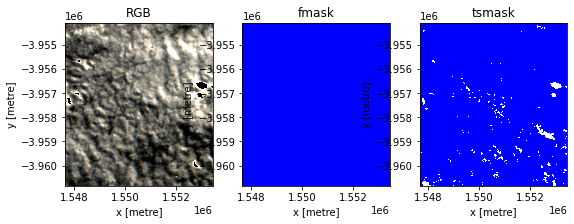

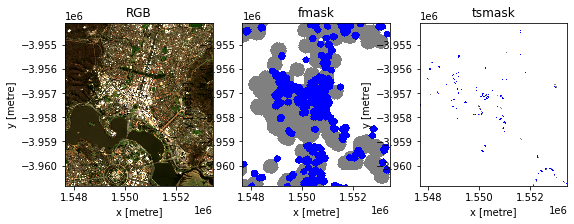

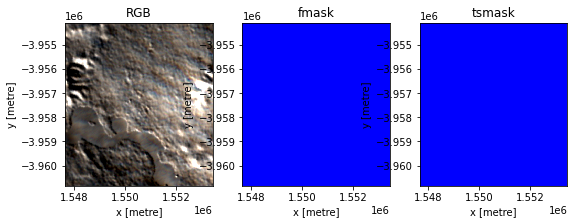

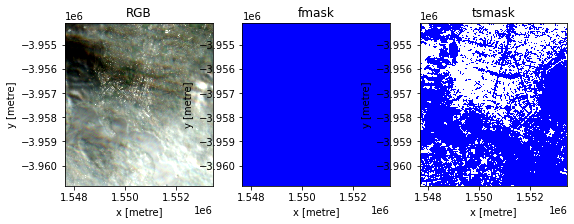

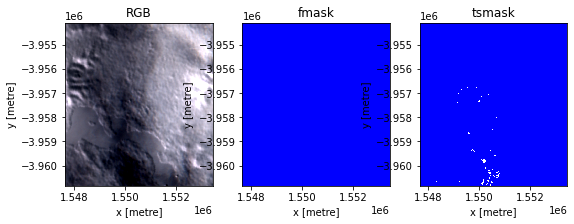

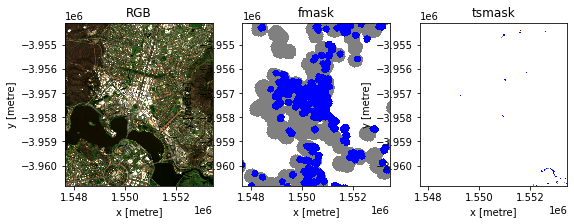

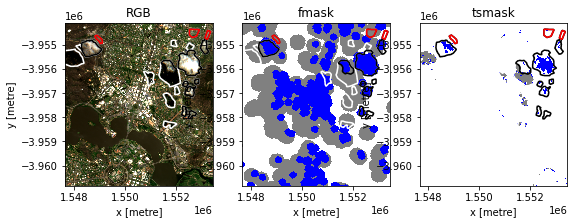

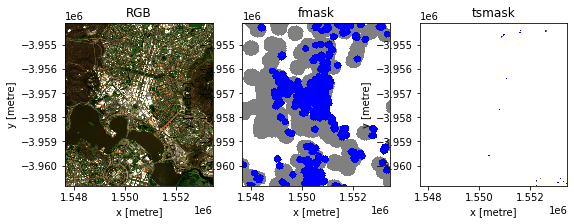

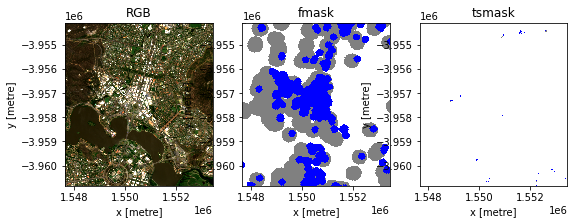

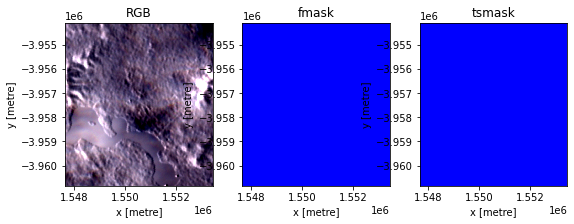

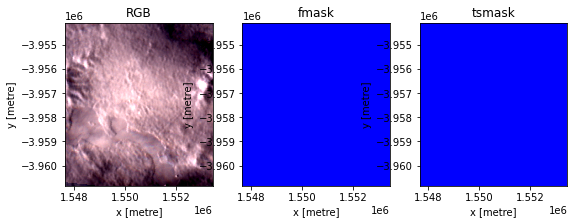

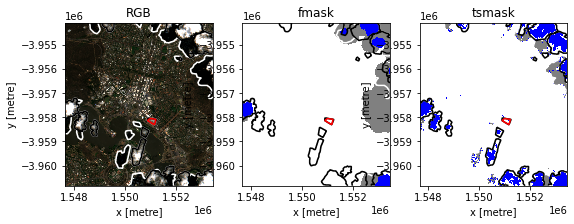

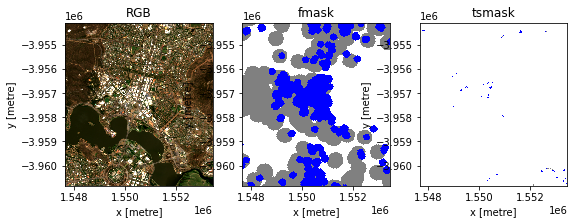

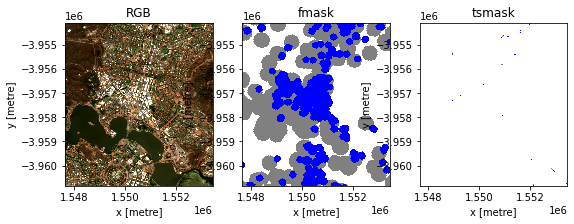

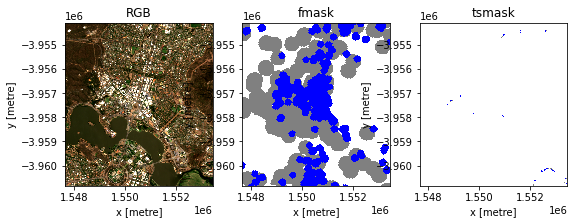

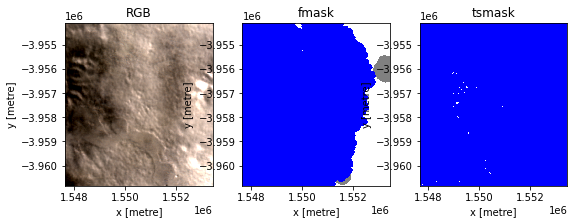

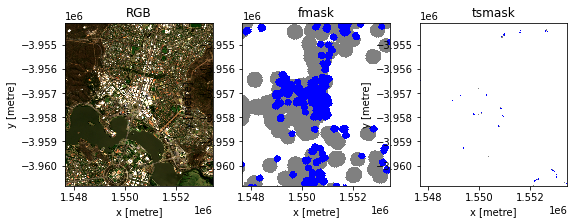

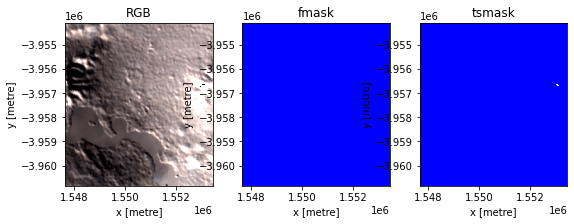

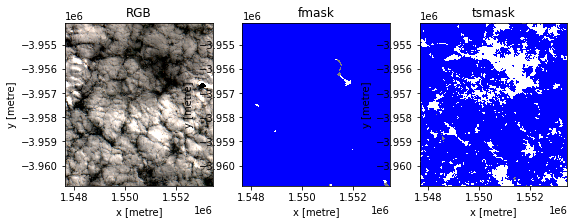

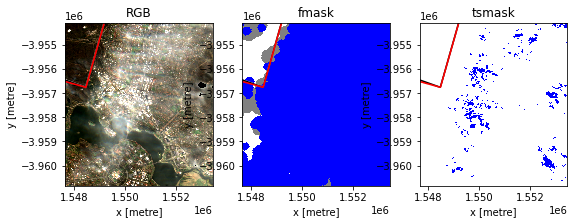

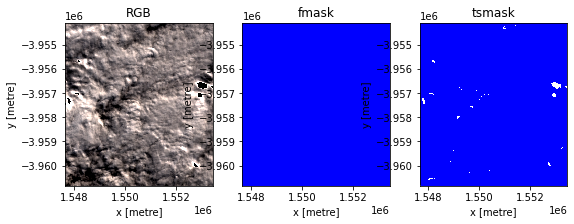

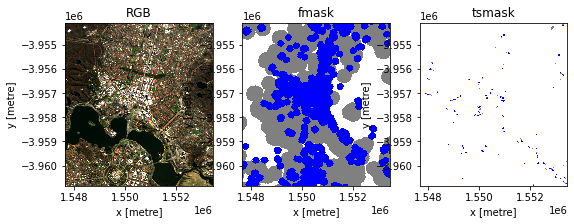

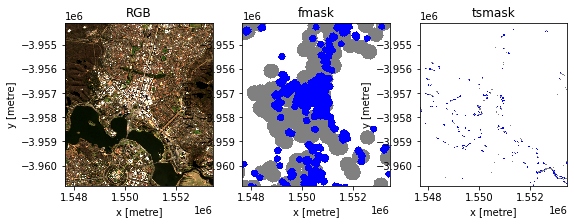

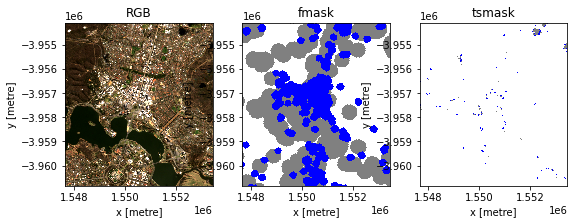

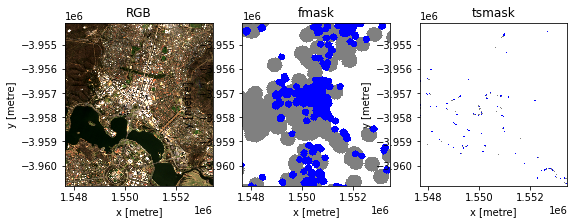

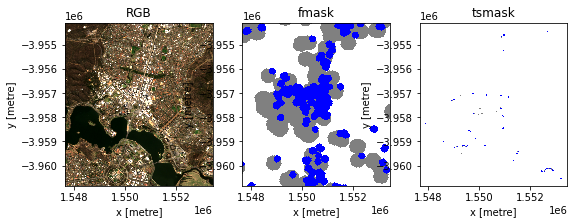

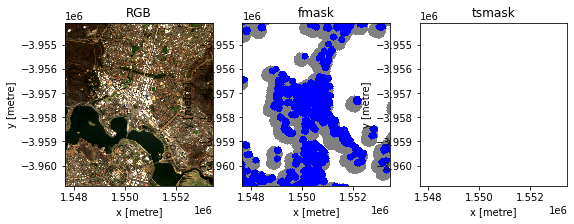

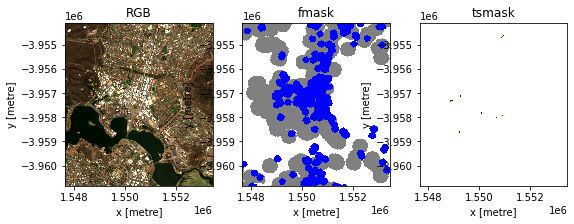

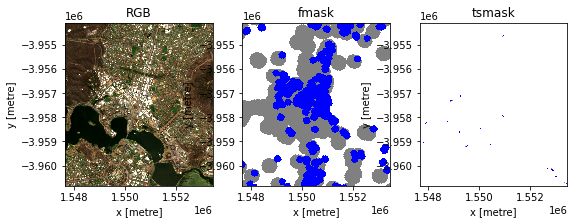

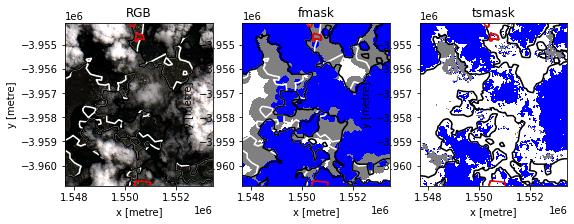

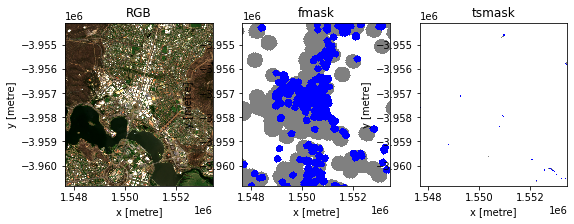

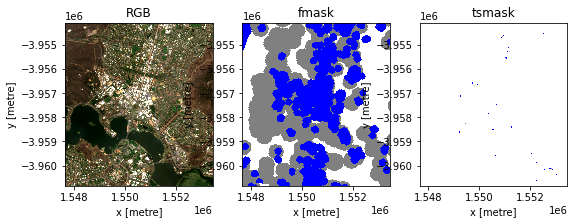

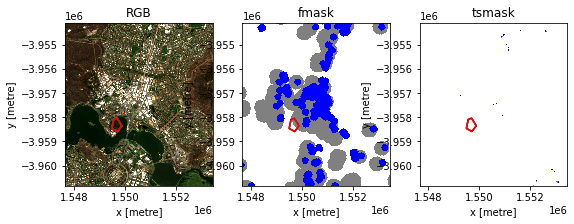

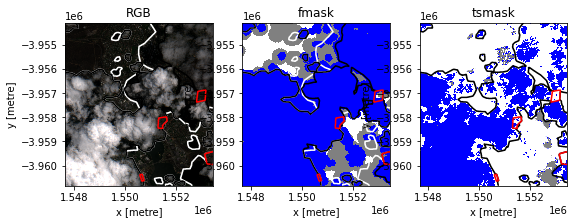

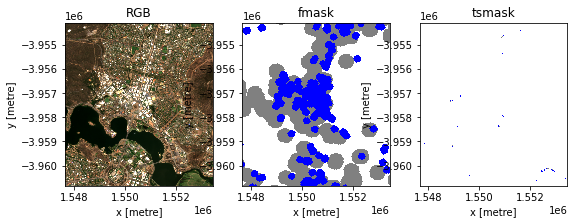

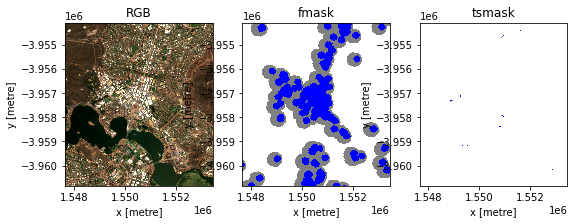

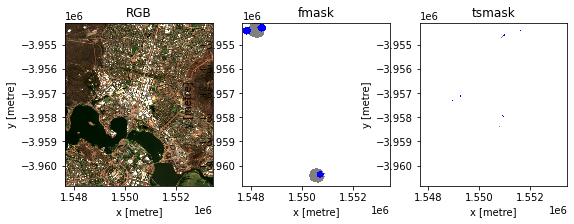

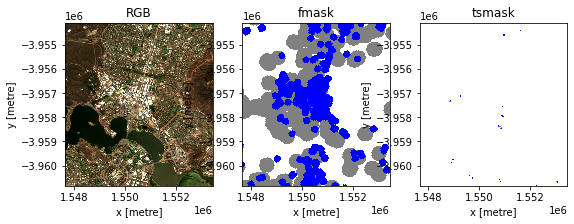

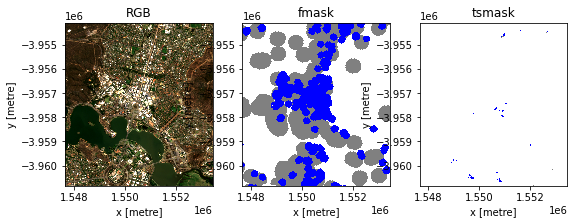

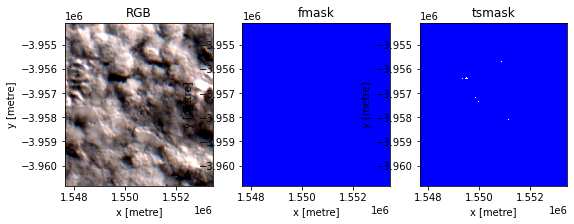

/env/lib/python3.6/site-packages/xarray/plot/plot.py:906: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)


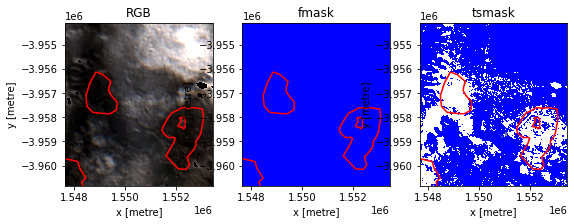

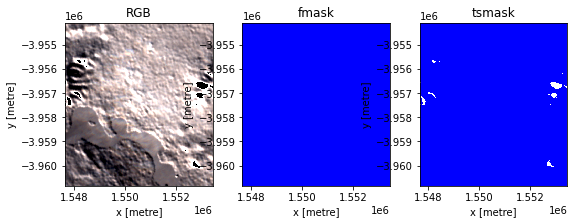

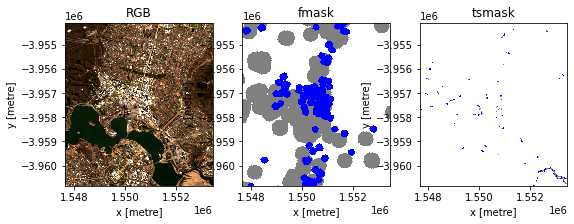

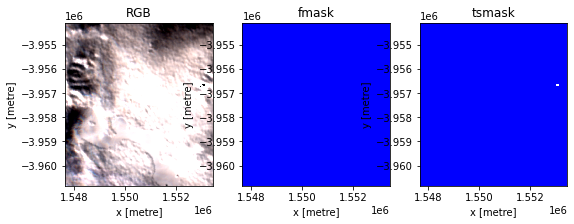

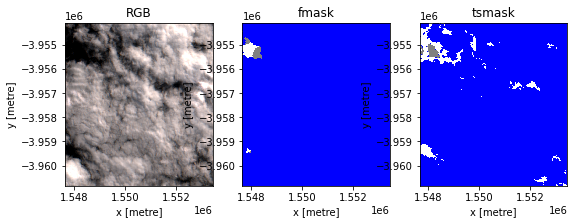

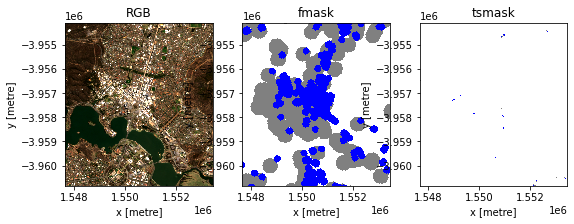

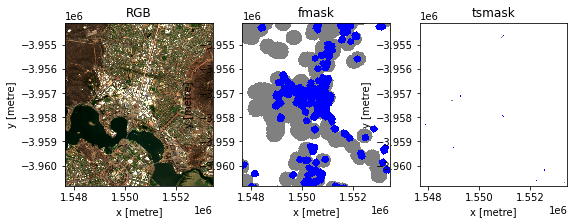

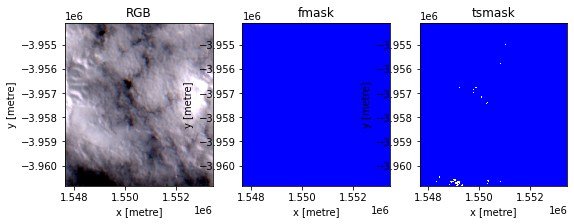

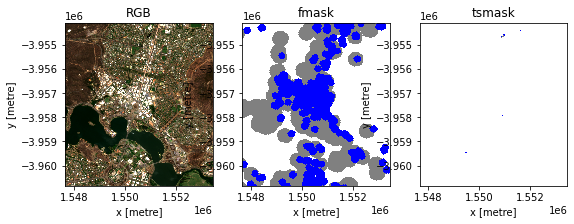

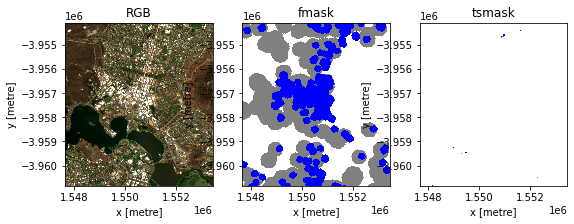

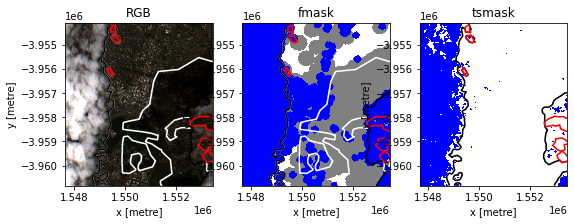

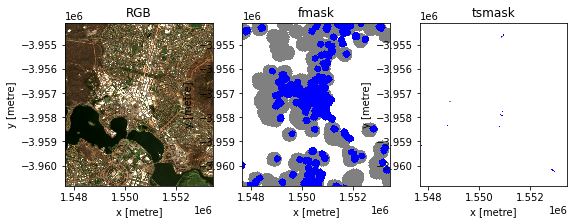

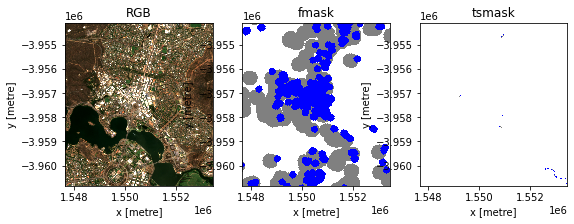

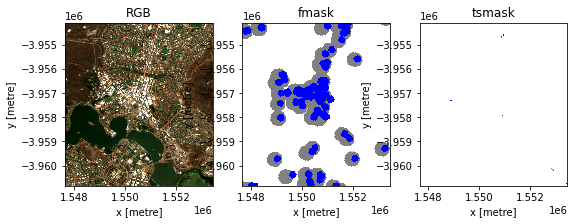

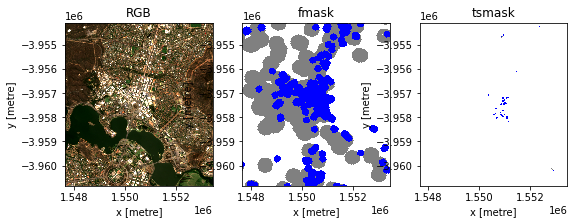

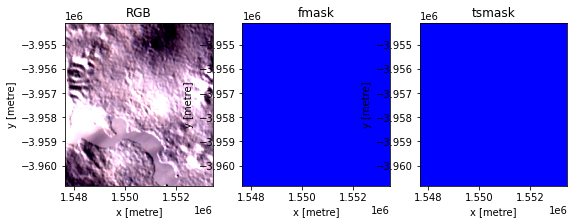

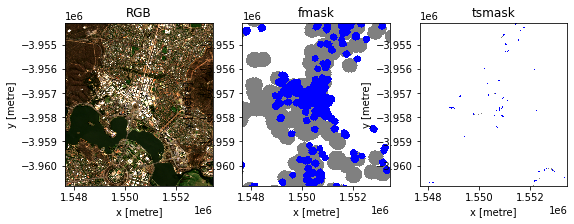

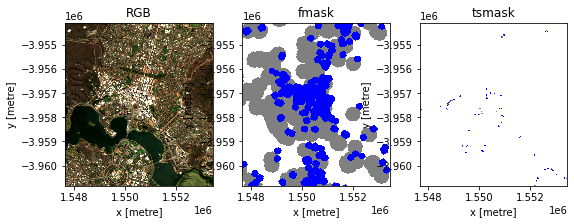

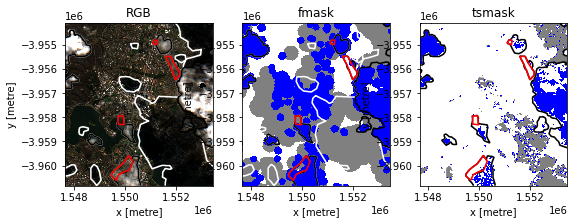

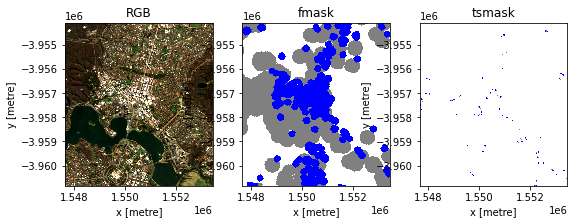

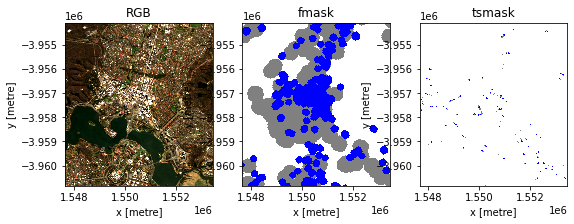

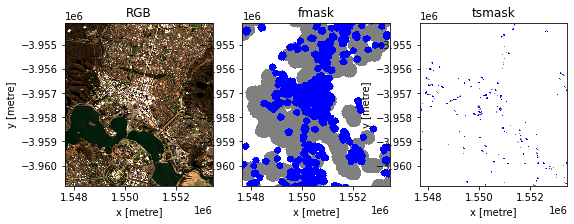

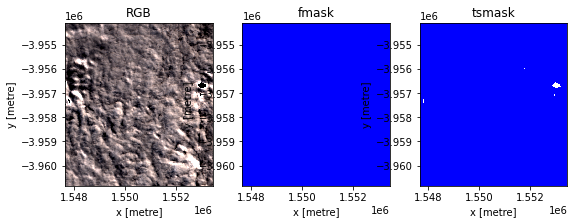

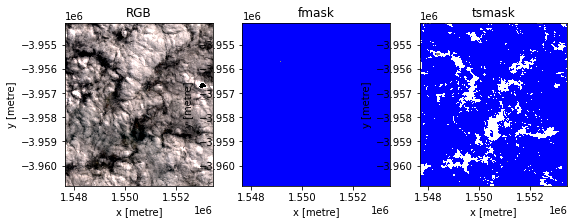

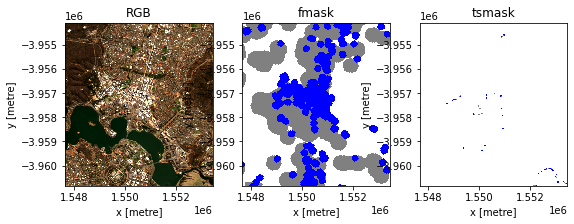

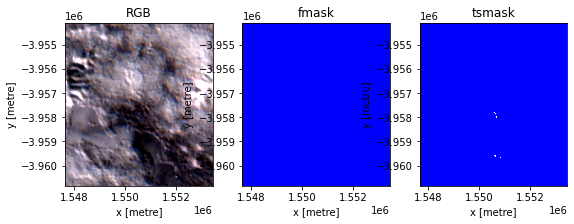

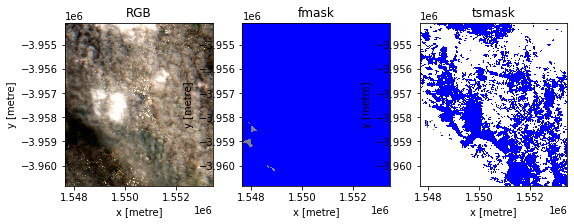

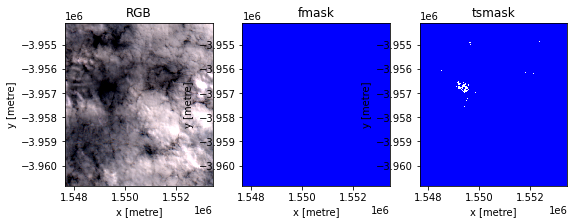

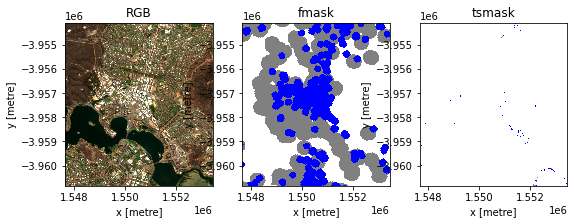

In [381]:
%matplotlib inline
test_times = read_labels.time
for t in test_times:
    if t.values not in fmask.time or t.values not in ds_tsmask.time:
        continue
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))
    time_labels = read_labels.sel(time=t)
    if not (time_labels[0, 0] == time_labels).all():
        for ax in [ax1, ax2, ax3]:
            time_labels.plot.contour(ax=ax, levels=[0, 1, 2, 3], colors=['white', 'black', 'red', 'orange'])
    rgb(ds.sel(time=t), ax=ax1)
    ax1.set_title('RGB')
    fmask_to_labels(fmask.sel(time=t)).plot(ax=ax2, cmap=mask_cmap, norm=mask_norm, add_colorbar=False)
    ax2.set_title('fmask')
    fmask_to_labels(ds_tsmask.sel(time=t).classification).plot(ax=ax3, cmap=mask_cmap, norm=mask_norm, add_colorbar=False)
    ax3.set_title('tsmask')
    plt.show()
    plt.close(fig)

Finally, let's compute a confusion matrix for each.

In [382]:
cms = [np.zeros((2, 2)), np.zeros((2, 2))]
test_times = read_labels.time
for t in tqdm(test_times):
    my_labels = read_labels.sel(time=t)
    my_labels = np.where(my_labels == 3, 2, my_labels)  # Ignore cloud transparency.
    try:
        fmask_labels = fmask_to_labels(fmask.sel(time=t)).values
        tsmask_labels = fmask_to_labels(ds_tsmask.sel(time=t).classification).values
    except KeyError:
        print('Missing:', t)
        continue
    for i, mask in enumerate([fmask_labels, tsmask_labels]):
        tp = (mask[my_labels == 2] == 2).sum()
        fp = (mask[my_labels != 2] == 2).sum()
        tn = (mask[my_labels != 2] != 2).sum()
        fn = (mask[my_labels == 2] != 2).sum()
        cms[i][0, 0] += tn
        cms[i][1, 1] += tp
        cms[i][1, 0] += fp
        cms[i][0, 1] += fn

Missing: <xarray.DataArray 'time' ()>
array('2019-11-01T00:02:41.024000000', dtype='datetime64[ns]')
Coordinates:
    spatial_ref  int32 3577
    time         datetime64[ns] 2019-11-01T00:02:41.024000
Missing: <xarray.DataArray 'time' ()>
array('2019-11-11T00:02:41.024000000', dtype='datetime64[ns]')
Coordinates:
    spatial_ref  int32 3577
    time         datetime64[ns] 2019-11-11T00:02:41.024000
Missing: <xarray.DataArray 'time' ()>
array('2019-11-21T00:02:41.024000000', dtype='datetime64[ns]')
Coordinates:
    spatial_ref  int32 3577
    time         datetime64[ns] 2019-11-21T00:02:41.024000
Missing: <xarray.DataArray 'time' ()>
array('2020-03-10T00:02:41.024000016', dtype='datetime64[ns]')
Coordinates:
    spatial_ref  int32 3577
    time         datetime64[ns] 2020-03-10T00:02:41.024000016
Missing: <xarray.DataArray 'time' ()>
array('2020-03-20T00:02:41.024000016', dtype='datetime64[ns]')
Coordinates:
    spatial_ref  int32 3577
    time         datetime64[ns] 2020-03-20T00:02:41

In [383]:
cms[0] / cms[0].sum(axis=0, keepdims=True)

array([[0.70226752, 0.18509072],
       [0.29773248, 0.81490928]])

In [384]:
cms[1] / cms[1].sum(axis=0, keepdims=True)

array([[2.62487230e-01, 8.05901262e-04],
       [7.37512770e-01, 9.99194099e-01]])

Let's print that in a nicer format.

In [385]:
assert cms[0][:, 1].sum() == cms[1][:, 1].sum()
print('fmask\t {:05.4f} \t TPR/Sensitivity'.format(cms[0][1, 1] / cms[0][:, 1].sum()))
print('tsmask\t {:05.4f} \t TPR/Sensitivity'.format(cms[1][1, 1] / cms[1][:, 1].sum()))
print('fmask \t {:05.4f} \t FPR'.format(cms[0][1, 0] / cms[0][:, 0].sum()))
print('tsmask \t {:05.4f} \t FPR'.format(cms[1][1, 0] / cms[1][:, 0].sum()))
print('fmask \t {:05.4f} \t TNR/Specificity'.format(cms[0][0, 0] / cms[0][:, 0].sum()))
print('tsmask \t {:05.4f} \t TNR/Specificity'.format(cms[1][0, 0] / cms[1][:, 0].sum()))
print('fmask \t {:05.4f} \t FNR'.format(cms[0][0, 1] / cms[0][:, 1].sum()))
print('tsmask \t {:05.4f} \t FNR'.format(cms[1][0, 1] / cms[1][:, 1].sum()))

fmask	 0.8149 	 TPR/Sensitivity
tsmask	 0.9992 	 TPR/Sensitivity
fmask 	 0.2977 	 FPR
tsmask 	 0.7375 	 FPR
fmask 	 0.7023 	 TNR/Specificity
tsmask 	 0.2625 	 TNR/Specificity
fmask 	 0.1851 	 FNR
tsmask 	 0.0008 	 FNR


Be aware that this confusion matrix is misleading: It's an expectation value over the sample we have selected. What we sample therefore affects the values. Even if we were to, say, class-balance (so there was equal cloud and not-cloud) then this might also not lead to a meaningful result, because, for example, clouds might be vastly less common than clear sky. I think the best expectation value would be over time, so weighting by how much cloud we expect to find in this region. This is approximately what we do if we upweight the mixed samples by how many total mixed samples there are, since we drew all the mixed samples from a larger set.

In [364]:
mixed_upweight = mixed.sum() / 9

In [366]:
cms = [np.zeros((2, 2)), np.zeros((2, 2))]
test_times = read_labels.time
for t, m in zip(tqdm(test_times), mixed):
    my_labels = read_labels.sel(time=t)
    my_labels = np.where(my_labels == 3, 2, my_labels)  # Ignore cloud transparency.
    try:
        fmask_labels = fmask_to_labels(fmask.sel(time=t)).values
        tsmask_labels = fmask_to_labels(ds_tsmask.sel(time=t).classification).values
    except KeyError:
        print('Missing:', t)
        continue
    for i, mask in enumerate([fmask_labels, tsmask_labels]):
        tp = (mask[my_labels == 2] == 2).sum()
        fp = (mask[my_labels != 2] == 2).sum()
        tn = (mask[my_labels != 2] != 2).sum()
        fn = (mask[my_labels == 2] != 2).sum()
        weight = mixed_upweight if m else 1
        cms[i][0, 0] += tn * weight
        cms[i][1, 1] += tp * weight
        cms[i][1, 0] += fp * weight
        cms[i][0, 1] += fn * weight

Missing: <xarray.DataArray 'time' ()>
array('2019-11-01T00:02:41.024000000', dtype='datetime64[ns]')
Coordinates:
    spatial_ref  int32 ...
    time         datetime64[ns] 2019-11-01T00:02:41.024000
Missing: <xarray.DataArray 'time' ()>
array('2019-11-11T00:02:41.024000000', dtype='datetime64[ns]')
Coordinates:
    spatial_ref  int32 ...
    time         datetime64[ns] 2019-11-11T00:02:41.024000
Missing: <xarray.DataArray 'time' ()>
array('2019-11-21T00:02:41.024000000', dtype='datetime64[ns]')
Coordinates:
    spatial_ref  int32 ...
    time         datetime64[ns] 2019-11-21T00:02:41.024000
Missing: <xarray.DataArray 'time' ()>
array('2020-03-10T00:02:41.024000016', dtype='datetime64[ns]')
Coordinates:
    spatial_ref  int32 ...
    time         datetime64[ns] 2020-03-10T00:02:41.024000016
Missing: <xarray.DataArray 'time' ()>
array('2020-03-20T00:02:41.024000016', dtype='datetime64[ns]')
Coordinates:
    spatial_ref  int32 ...
    time         datetime64[ns] 2020-03-20T00:02:41.0240

In [371]:
assert np.isclose(cms[0][:, 1].sum(), cms[1][:, 1].sum())
print('fmask\t {:05.4f} \t TPR/Sensitivity'.format(cms[0][1, 1] / cms[0][:, 1].sum()))
print('tsmask\t {:05.4f} \t TPR/Sensitivity'.format(cms[1][1, 1] / cms[1][:, 1].sum()))
print('fmask \t {:05.4f} \t FPR'.format(cms[0][1, 0] / cms[0][:, 0].sum()))
print('tsmask \t {:05.4f} \t FPR'.format(cms[1][1, 0] / cms[1][:, 0].sum()))
print('fmask \t {:05.4f} \t TNR/Specificity'.format(cms[0][0, 0] / cms[0][:, 0].sum()))
print('tsmask \t {:05.4f} \t TNR/Specificity'.format(cms[1][0, 0] / cms[1][:, 0].sum()))
print('fmask \t {:05.4f} \t FNR'.format(cms[0][0, 1] / cms[0][:, 1].sum()))
print('tsmask \t {:05.4f} \t FNR'.format(cms[1][0, 1] / cms[1][:, 1].sum()))

fmask	 0.9943 	 TPR/Sensitivity
tsmask	 0.8912 	 TPR/Sensitivity
fmask 	 0.1995 	 FPR
tsmask 	 0.0042 	 FPR
fmask 	 0.8005 	 TNR/Specificity
tsmask 	 0.9958 	 TNR/Specificity
fmask 	 0.0057 	 FNR
tsmask 	 0.1088 	 FNR


Weighting does affect the result (by about 1%).

In [386]:
cms = [np.zeros((2, 2)), np.zeros((2, 2))]
test_times = read_labels.time
all_me = []
all_fm = []
all_tm = []
for t in tqdm(test_times):
    my_labels = read_labels.sel(time=t)
    my_labels = np.where(my_labels == 3, 2, my_labels)  # Ignore cloud transparency.
    try:
        fmask_labels = fmask_to_labels(fmask.sel(time=t)).values
        tsmask_labels = fmask_to_labels(ds_tsmask.sel(time=t).classification).values
    except KeyError:
        print('Missing:', t)
        continue
    all_me.append(my_labels.ravel())
    all_fm.append(fmask_labels.ravel())
    all_tm.append(tsmask_labels.ravel())

Missing: <xarray.DataArray 'time' ()>
array('2019-11-01T00:02:41.024000000', dtype='datetime64[ns]')
Coordinates:
    spatial_ref  int32 3577
    time         datetime64[ns] 2019-11-01T00:02:41.024000
Missing: <xarray.DataArray 'time' ()>
array('2019-11-11T00:02:41.024000000', dtype='datetime64[ns]')
Coordinates:
    spatial_ref  int32 3577
    time         datetime64[ns] 2019-11-11T00:02:41.024000
Missing: <xarray.DataArray 'time' ()>
array('2019-11-21T00:02:41.024000000', dtype='datetime64[ns]')
Coordinates:
    spatial_ref  int32 3577
    time         datetime64[ns] 2019-11-21T00:02:41.024000
Missing: <xarray.DataArray 'time' ()>
array('2020-03-10T00:02:41.024000016', dtype='datetime64[ns]')
Coordinates:
    spatial_ref  int32 3577
    time         datetime64[ns] 2020-03-10T00:02:41.024000016
Missing: <xarray.DataArray 'time' ()>
array('2020-03-20T00:02:41.024000016', dtype='datetime64[ns]')
Coordinates:
    spatial_ref  int32 3577
    time         datetime64[ns] 2020-03-20T00:02:41

In [387]:
import sklearn.metrics

In [395]:
sklearn.metrics.confusion_matrix(np.concatenate(all_me), np.concatenate(all_fm))

array([[ 9945455,  5653483,  3643420],
       [   37722,   248168,    67491],
       [  110599,    58161, 11447501]])

In [396]:
sklearn.metrics.confusion_matrix(np.concatenate(all_me), np.concatenate(all_tm))

array([[19164444,    18452,    59462],
       [  240537,    92758,    20086],
       [ 1295228,     6417, 10314616]])

In [397]:
Out[395] / Out[395].sum(axis=0, keepdims=True)

array([[0.9853057 , 0.9486009 , 0.24035631],
       [0.00373715, 0.04164024, 0.00445238],
       [0.01095715, 0.00975886, 0.75519131]])

In [398]:
Out[396] / Out[396].sum(axis=0, keepdims=True)

array([[0.9258092 , 0.15686875, 0.00572071],
       [0.01162003, 0.78857745, 0.00193243],
       [0.06257077, 0.0545538 , 0.99234686]])

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** August 2020

**Compatible datacube version:** 

In [18]:
print(datacube.__version__)

1.8.2.dev7+gdcab0e02


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)

**Tags**: :index:`NCI compatible`, :index:`sandbox compatible`, :index:`sentinel 2`, :index:`time series`